In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install bayesian-optimization

In [1]:
import tensorflow as tf
import cv2, os
import glob
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from tensorflow.python.keras.optimizer_v2 import rmsprop

In [ ]:
# 리얼 흑백이미지 폴더 glob
F_list = len(glob.glob(f"/content/drive/MyDrive/resized/Real_img*/*.jpg"))
print(F_list)

# 페이크 흑백이미지 폴더 glob
F_list = len(glob.glob(f"/content/drive/MyDrive/resized/Fake_img*/*.jpg"))
print(F_list)

109864
101096


In [ ]:
label_dict = {"Fake_img":1,"Real_img":0}
categories = ["Fake_img", "Real_img"]
folder_num = 2

# 구글드라이브 타임아웃 에러 방지용 (한번씩 glob 함으로써 0으로 읽는 거 방지)
# 리얼 이미지 폴더 glob
destination_folder = f'/content/drive/MyDrive/aihub_test/Real_img{folder_num}'
F_list = len(glob.glob(f"{destination_folder}/*"))
print(F_list)

# 리얼 이미지 폴더 glob
destination_folder = f'/content/drive/MyDrive/aihub_test/Fake_img{folder_num}'
F_list = len(glob.glob(f"{destination_folder}/*"))
print(F_list)

# 리얼 흑백이미지 폴더 glob
destination_folder = f'/content/drive/MyDrive/resized/Real_img*'
F_list = len(glob.glob(f"{destination_folder}/*.jpg"))
print(F_list)

# 페이크 흑백이미지 폴더 glob
destination_folder = f'/content/drive/MyDrive/resized/Fake_img*'
F_list = len(glob.glob(f"{destination_folder}/*.jpg"))
print(F_list)

# 리얼 이미지 폴더 glob
destination_folder = '/content/drive/MyDrive/model'
F_list = len(glob.glob(f"{destination_folder}/*"))
print(F_list)

# 원본 폴더에서 사진을 읽어와서 전처리
for category in categories:
    img_names=glob.glob(f"/content/drive/MyDrive/aihub_test/{category}{folder_num}/*.jpg")
    print(len(img_names))

    for img_name in img_names:
        img=cv2.imread(img_name)

        try:
            # 100 * 100 의 흑백 사진으로 저장
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            resized=cv2.resize(gray,(100, 100))
            name = img_name.split("/")[-1]
            save_file_path = f"/content/drive/MyDrive/resized/{category}/{name}_gray.jpg"
            cv2.imwrite(save_file_path, resized)
            print(name, "완료")

        except Exception as e:
            print('Exception:', e)

In [ ]:
label_dict = {"Fake_img":1,"Real_img":0}
categories = ["Fake_img", "Real_img"]

data=[]
target=[]

# 저장한 흑백 파일들 읽어옴
for category in categories:
    img_names=glob.glob(f"/content/drive/MyDrive/resized/{category}*/*.jpg")
    print(len(img_names))

    for img_name in img_names:
        img=cv2.imread(img_name)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            data.append(gray)
            target.append(label_dict[category])

        except Exception as e:
            print('Exception:', e)

# target에 제대로 들어갔는지 개수 확인
from collections import Counter
counter = Counter(target)
print("target:",counter)


data=np.array(data)/255.0 # 스케일링
# 모델의 입력은 4차원 텐서여야 함
data=np.reshape(data,(data.shape[0], 100, 100, 1)) # (사진 장수, 가로픽셀, 세로픽셀, 채널)

# 타겟은 2차원 numpy array임
target=np.array(target)
target = to_categorical(target)

# 데이터, 타겟(라벨) 형태 확인
print("data.shape:",data.shape)
print("target.shape:",target.shape)

# Train Test Split
from sklearn.model_selection import train_test_split
x_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)

# (사진 장수, 가로, 세로, 채널) 에서 (가로, 세로, 채널) 입력 사이즈 확인
input_shape=data.shape[1:]
input_shape

101096


In [ ]:
def get_model(input_shape, dropout2_rate=0.5):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,
                     name="conv2d_1"))
    model.add(Conv2D(64, (3, 3), activation='relu', name="conv2d_2"))
    model.add(MaxPooling2D(pool_size=(2, 2), name="maxpool2d_1"))
    model.add(Dropout(0.25, name="dropout_1"))
    model.add(Flatten(name="flatten"))
    model.add(Dense(128, activation='relu', name="dense_1"))
    model.add(Dropout(dropout2_rate, name="dropout_2"))
    model.add(Dense(2, activation='softmax', name="dense_2"))
    return model

def fit_with(input_shape, verbose, dropout2_rate, lr):

    model = get_model(input_shape, dropout2_rate)

    optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)
    model.compile(loss="binary_crossentropy",
                  optimizer=optimizer,
                  metrics=['accuracy'])

    model.fit(x_train, y_train, epochs=10,
              batch_size=10, verbose=verbose)

    score = model.evaluate(X_test, y_test, steps=10, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    return score[1]


from functools import partial

verbose = 1
fit_with_partial = partial(fit_with, input_shape, verbose)

from bayes_opt import BayesianOptimization

pbounds = {'dropout2_rate': (0.1, 0.5), 'lr': (1e-4, 1e-2)}

optimizer = BayesianOptimization(
    f=fit_with_partial,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

optimizer.maximize(init_points=10, n_iter=10)

for i, res in enumerate(optimizer.res):
    print(f"Iteration {i}: \n\t{res}")

In [2]:
# 모델 설계
model=Sequential()
model.add(Conv2D(32,kernel_size=(3,3),input_shape=data.shape[1:], activation='relu'))
model.add(Conv2D(64,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1587))
model.add(Dense(2, activation='softmax'))
model.summary

NameError: name 'data' is not defined

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# 업데이트 없으면 미리 학습 중단
early_stopping = EarlyStopping(monitor='val_loss', patience=50)

# 모델 체크포인트
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/model/{epoch:03d}-{val_loss:.4f}.hdf5', # 모델을 저장할 위치 설정!!
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    mode='auto')

In [ ]:
# 모델 피팅
history=model.fit(x_train, y_train,
                  epochs=100,
                  batch_size=10,
                  callbacks=[checkpoint, early_stopping],
                  validation_data=(X_test, y_test))

Epoch 1/100
3362/3362 [==============================] - ETA: 0s - loss: 0.3989 - accuracy: 0.8052

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3362/3362 [==============================] - 40s 10ms/step - loss: 0.3989 - accuracy: 0.8052 - val_loss: 0.1865 - val_accuracy: 0.9237
Epoch 2/100
3362/3362 [==============================] - 33s 10ms/step - loss: 0.1534 - accuracy: 0.9375 - val_loss: 0.0989 - val_accuracy: 0.9574
Epoch 3/100
3362/3362 [==============================] - 33s 10ms/step - loss: 0.0991 - accuracy: 0.9604 - val_loss: 0.0686 - val_accuracy: 0.9716
Epoch 4/100
3362/3362 [==============================] - 32s 10ms/step - loss: 0.0733 - accuracy: 0.9712 - val_loss: 0.0743 - val_accuracy: 0.9738
Epoch 5/100
3362/3362 [==============================] - 33s 10ms/step - loss: 0.0570 - accuracy: 0.9776 - val_loss: 0.0457 - val_accuracy: 0.9810
Epoch 6/100
3362/3362 [==============================] - 33s 10ms/step - loss: 0.0498 - accuracy: 0.9803 - val_loss: 0.0364 - val_accuracy: 0.9861
Epoch 7/100
3362/3362 [==============================] - 33s 10ms/step - loss: 0.0424 - accuracy: 0.9836 - val_loss: 0.0272 - val_

In [ ]:
# evaluate
print(model.evaluate(X_test, y_test))

263/263 [==============================] - 2s 6ms/step - loss: 0.0188 - accuracy: 0.9975
[0.01876751333475113, 0.9975011944770813]


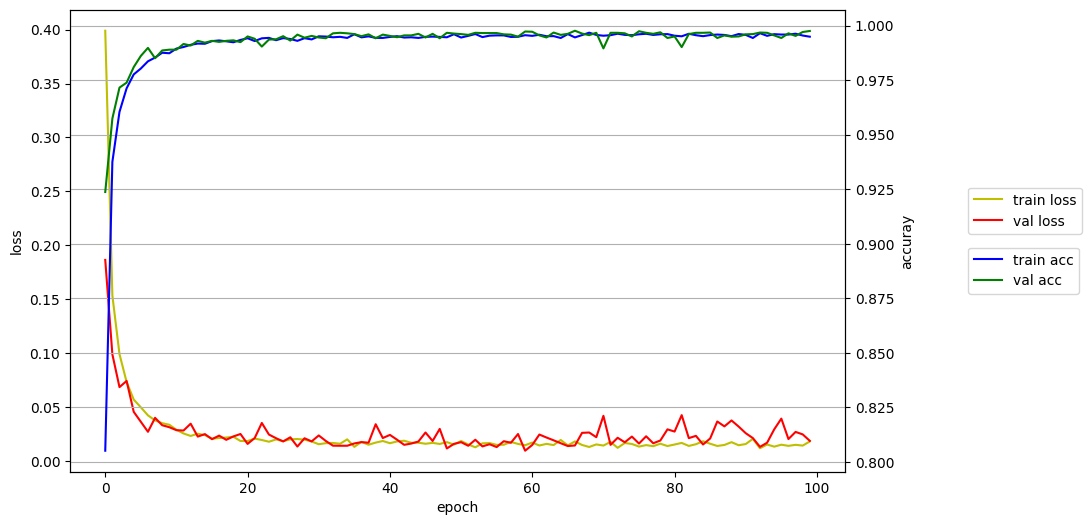

In [ ]:
# 학습 그래프 그리기
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(10,6))
acc_ax = loss_ax.twinx()

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

acc_ax.legend(loc='upper left', bbox_to_anchor=(1.15, 0.5))
loss_ax.legend(loc='lower left', bbox_to_anchor=(1.15, 0.5))

plt.grid()
plt.show()

In [ ]:
from keras.models import load_model

# 제일 잘된 모델 로드
model = load_model("/content/drive/MyDrive/model/060-0.0096.hdf5")

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# X_test로 만든 pred
pred = model.predict(X_test)

263/263 [==============================] - 1s 4ms/step


In [ ]:
import numpy as np

# 임계값(threshold) 설정
threshold = 0.5

# 확률값을 임계값에 따라 0 또는 1로 변환
pred_binary = np.where(pred > threshold, 1, 0)

In [ ]:
# 2차원인 y_test를 1차원으로 변경 (Fake와 Real중 큰 쪽을 택1)
# confusion matrix, f1-score, 재현율, 정확도 구하기 위함

label_test = np.argmax(y_test,axis=1)
label_test

array([0, 1, 0, ..., 1, 1, 0])

In [ ]:
# 2차원인 pred_binary를 1차원으로 변경 (Fake와 Real중 큰 쪽을 택1)
# confusion matrix, f1-score, 재현율, 정확도 구하기 위함

label_pred = np.argmax(pred_binary,axis=1)
label_pred

array([0, 1, 0, ..., 1, 1, 0])

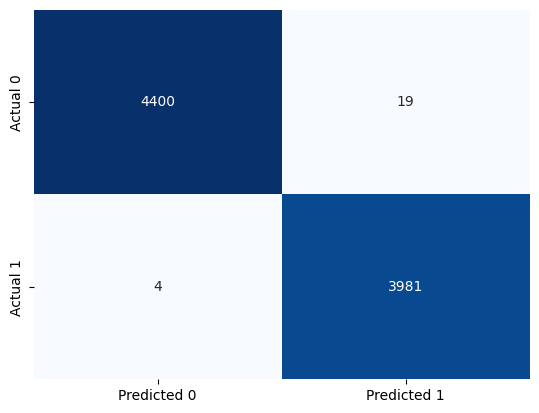

In [ ]:
# confusion matrix 이쁘게
import seaborn as sns
cm = confusion_matrix(label_test, label_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.show()

In [ ]:
# 간략하게 나오는건데 일단 무시해도 됨
print(classification_report(label_test, label_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4419
           1       1.00      1.00      1.00      3985

    accuracy                           1.00      8404
   macro avg       1.00      1.00      1.00      8404
weighted avg       1.00      1.00      1.00      8404



In [ ]:
from sklearn.metrics import f1_score, recall_score, accuracy_score

# F1, acc, recall 구하기
f1_score = f1_score(label_test, label_pred)
acc_score = accuracy_score(label_test, label_pred)
recall_score = recall_score(label_test, label_pred)

print("F1-score:")
print(f"{f1_score:0.5f}")

print("acc-score:")
print(f"{acc_score:0.5f}")

print("recall-score:")
print(f"{recall_score:0.5f}")

F1-score:
0.9971195992485911
acc-score:
0.9972632079961923
recall-score:
0.9989962358845671
